AIM: To perform intent classification using small BERT.

In [ ]:
# install required libraries
# dependency of the preprocessing for BERT inputs
print('installing tensorflow-text library...')
!pip install -q -U "tensorflow-text==2.8.*"
print('tensorflow-text library installation complete...')

installing tensorflow-text library...
     |████████████████████████████████| 4.9 MB 42.1 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 5.8 MB 68.3 MB/s 
     |████████████████████████████████| 1.4 MB 63.6 MB/s 
     |████████████████████████████████| 462 kB 67.7 MB/s 
tensorflow-text library installation complete...


In [ ]:
# import libraries
from google.colab import drive
import os

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# mount google drive and connect working directory
drive.mount('/content/gdrive', force_remount = True)
print (sorted(os.listdir('gdrive/My Drive/Colab Helper/ICData/Dataset')))
os.chdir('gdrive/My Drive/Colab Helper/ICData/Dataset') # Connect to the directory

Mounted at /content/gdrive
['data_file.csv', 'glove.6B.100d.txt', 'glove.6B.50d.txt', 'model', 'model.png', 'saved_model', 'test_.csv', 'train_.csv', 'valid_.csv']


In [ ]:
# read train file and print it's shape
traindf = pd.read_csv('train_.csv', usecols=['text','intent'])
testdf = pd.read_csv('test_.csv', usecols=['text','intent'])
validdf = pd.read_csv('valid_.csv', usecols=['text','intent'])

print('Train Shape: ', traindf.shape)
print('Test Shape: ', testdf.shape)
print('Valid Shape: ', validdf.shape)

Train Shape:  (9951, 2)
Test Shape:  (1280, 2)
Valid Shape:  (2985, 2)


Observation:

1.   No NULL value present.

In [ ]:
# NULL value presence check
print('NULL values: ', traindf['text'].isnull().sum())

NULL values:  0


Observation:

1.   Texts may not require a lot of text cleaning.

In [ ]:
# display first 10 rows
print('First 10 rows:\n', traindf.head(10))

First 10 rows:
                                                 text              intent
0                          find under night in-birth  SearchCreativeWork
1         book a spot in town in the same area as me      BookRestaurant
2                                         fimd glory  SearchCreativeWork
3       i need a restaurant on july 18th in rose bud      BookRestaurant
4  book a spot for 4 in oklahoma at south street ...      BookRestaurant
5  i need to know what the weather will be like i...          GetWeather
6  book a bistro in new zealand in 119 and a half...      BookRestaurant
7           need a table for nine in east prairie la      BookRestaurant
8  book a table for mindy and angelita at a resta...      BookRestaurant
9  find me a table for two at seven somewhere in ...      BookRestaurant


**Process Inputs**

In [ ]:
# label encode
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(traindf['intent']) # fit label encoder
print('Label Encoder Classes: ', label_encoder.classes_)

# transform labels
traindf['intent'] = label_encoder.transform(traindf['intent'])
testdf['intent'] = label_encoder.transform(testdf['intent'])
validdf['intent'] = label_encoder.transform(validdf['intent'])

Label Encoder Classes:  ['AddToPlaylist' 'BookRestaurant' 'GetWeather' 'PlayMusic' 'RateBook'
 'SearchCreativeWork' 'SearchScreeningEvent']


In [ ]:
# convert model input data to arrays
x_train = np.array([np.array(val) for val in traindf['text']])
x_val = np.array([np.array(val) for val in validdf['text']])

y_train = np.array([np.array(val) for val in traindf['intent']])
y_val = np.array([np.array(val) for val in validdf['intent']])

**Define Model and Preprocessor**

In [ ]:
# get model and it's preprocessor URL
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1" # model
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3" # preprocesser

print('BERT model selected           : {}'.format(tfhub_handle_encoder))
print('Preprocess model auto-selected: {}'.format(tfhub_handle_preprocess))

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


**Model Training**

In [ ]:
# model definition
# bert layers
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') # preprocesser for bert
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') # bert model

# using bert layers on input
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input') # input
encoder_inputs = preprocessing_layer(text_input) 
outputs = encoder(encoder_inputs)

# neural network layers
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(7, activation='softmax', name='classifier')(net)

# using inputs and outputs to construct a final model
model = tf.keras.Model(inputs=text_input, outputs=net)

# model name and summary
model._name = 'SmallBERTuncased'
model.summary()

Model: "SmallBERTuncased"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text_input[0][0]']             
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                       

In [ ]:
# model compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

# model training
epochs = 5
%time history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)

Epoch 1/5
311/311 [==============================] - 37s 104ms/step - loss: 0.2069 - accuracy: 0.9375 - val_loss: 0.0826 - val_accuracy: 0.9762
Epoch 2/5
311/311 [==============================] - 29s 93ms/step - loss: 0.0871 - accuracy: 0.9758 - val_loss: 0.0841 - val_accuracy: 0.9782
Epoch 3/5
311/311 [==============================] - 28s 91ms/step - loss: 0.0611 - accuracy: 0.9845 - val_loss: 0.1015 - val_accuracy: 0.9725
Epoch 4/5
311/311 [==============================] - 28s 91ms/step - loss: 0.0628 - accuracy: 0.9844 - val_loss: 0.1001 - val_accuracy: 0.9735
Epoch 5/5
311/311 [==============================] - 31s 98ms/step - loss: 0.0437 - accuracy: 0.9885 - val_loss: 0.1214 - val_accuracy: 0.9712
CPU times: user 3min 6s, sys: 34.1 s, total: 3min 40s
Wall time: 2min 33s


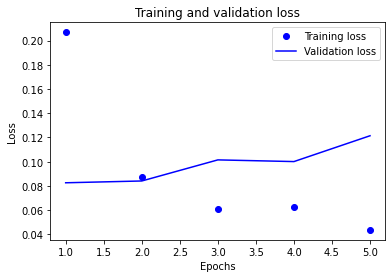

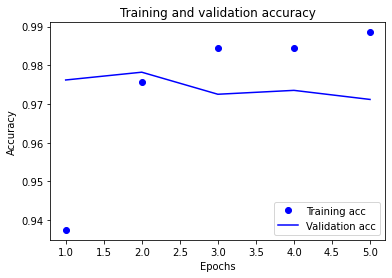

In [ ]:
# plot the graphs
history_dict = history.history # dictionary of result values
epochs = range(1, len(history_dict['accuracy']) + 1) # number of epochs

# plot for loss
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot for accuracy
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

**Evaluate Model**

In [ ]:
# evaluate model on test dataset
x_test = np.array([np.array(val) for val in testdf['text']])
y_test = np.array([np.array(val) for val in testdf['intent']])
# model evaluation
print('Model Evaluation on Test Set:')
loss, accuracy = model.evaluate(x_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Model Evaluation on Test Set:
40/40 [==============================] - 3s 62ms/step - loss: 0.1064 - accuracy: 0.9758
Loss:  0.10639981180429459
Accuracy:  0.975781261920929


**Export Model**

In [ ]:
# save the model
model.save('saved_model/model_smallbert', save_format='tf')

**Conclusion:**

**Model (smallBERTuncased L-2_H-128_A-2):**
1.   Epochs: 5
2.   Loss and Accuracy:
    *   Training Loss: 0.0437 - Training Accuracy: 0.9885
    *   Validation Loss: 0.1214 - Validation Accuracy: 0.9712
    *   Testing Loss: 0.1063 - Testing Accuracy: 0.9757
3.   Wall Time: 2min 33s

**ANALYSIS:**
1.   Model quickly overfits the data.
    *   Reason: The data isn't complex/hard to learn for a BERT like model.
